In [ ]:
"""
This file does the finetuning work necessary for the classification of
Yelp reviews that do or do not mention that the place they are for offers
live music.

NOTE: Everything here is highly based on Stephen Hansen's GitHub tutorial
at https://github.com/sekhansen/columbia_lectures_2025/blob/main/code/03_classification_bert.ipynb
and his paper REMOTE WORK ACROSS JOBS, COMPANIES, AND SPACE (Hansen et al.)
"""
import pandas as pd
import numpy as np
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
from datasets import Dataset
import evaluate
import random

In [5]:
# setup
# Set seeds for reproducibility
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# Set seed at the beginning
set_seed(42)

# setup running on GPU
device = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")
print(f"Using device: {device}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"CUDA device count: {torch.cuda.device_count()}")
    print(f"CUDA device name: {torch.cuda.get_device_name(0)}")
elif torch.backends.mps.is_available():
    print("Using Apple Metal Performance Shaders (MPS)")

Using device: mps
CUDA available: False
Using Apple Metal Performance Shaders (MPS)


In [6]:
# load data
df = pd.read_csv("./finetuning_reviews.csv", encoding='utf-8')

Prepare data for finetuning

In [7]:
# perform train-test split

n = len(df)
test_size = int(0.1 * n)
indices = np.random.RandomState(95).permutation(n)
train_idxs, test_idxs = indices[test_size:], indices[:test_size]


In [8]:
df_finetune = df.iloc[train_idxs][["text", "live_music"]].copy()
df_finetune['labels'] = df_finetune['live_music']
print(df_finetune.shape)

df_test = df.iloc[test_idxs][["text", "live_music"]].copy()
df_test['labels'] = df_test['live_music']
print(df_test.shape)

(8982, 3)
(997, 3)


In [9]:
df_finetune.head()

,text,live_music,labels
6098,Came here at happy hour on a Friday night; ver...,0,0
4236,"Visiting from Baltimore, MD, we were out walki...",0,0
5195,Being a lover of all foods I have to keep my m...,0,0
6714,I got a Groupon and had been meaning to try th...,0,0
2343,"Impressive first visit to the C House, in Semi...",1,1


Finetune!

In [10]:
# transform data into Dataset class
finetune_dataset = Dataset.from_pandas(df_finetune)
test_dataset = Dataset.from_pandas(df_test)

In [11]:
# we use cased to identify proper nouns
tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")

# tokenize the dataset
def tokenize_function(examples):
    return tokenizer(examples["text"], max_length=512, padding="max_length", truncation=True)


# batched=True is key for training
tokenized_ft = finetune_dataset.map(tokenize_function, batched=True)
tokenized_test = test_dataset.map(tokenize_function, batched=True)

Map:   0%|          | 0/8982 [00:00<?, ? examples/s]

Map:   0%|          | 0/997 [00:00<?, ? examples/s]

In [12]:
model_ft = AutoModelForSequenceClassification.from_pretrained(
    "bert-base-cased",
    num_labels=2
)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [13]:
training_args = TrainingArguments(
    output_dir="./",                # path to save model
    learning_rate=5e-5,             # small learning rates
    num_train_epochs=2,             # number of finetuning passes
    per_device_train_batch_size=8,  # batch size per GPU
    per_device_eval_batch_size=8,   # batch size per GPU
    eval_strategy="epoch",          # See metrics during training
    save_strategy="no",             # Don't save checkpoints
    report_to="none",               # Don't report model estimation externally
)

In [14]:
# model performance metrics

metric_precision = evaluate.load("precision")
metric_recall = evaluate.load("recall")
metric_f1 = evaluate.load("f1")
metric_accuracy = evaluate.load("accuracy")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)

    precision = metric_precision.compute(predictions=predictions, references=labels, average="micro")["precision"]
    recall = metric_recall.compute(predictions=predictions, references=labels, average="micro")["recall"]
    f1 = metric_f1.compute(predictions=predictions, references=labels, average="micro")["f1"]
    accuracy = metric_accuracy.compute(predictions=predictions, references=labels)["accuracy"]

    return {"precision": precision, "recall": recall, "f1": f1, "accuracy": accuracy}

In [15]:
print(f"Training samples: {len(tokenized_ft)}")
print(f"Batches per epoch: {len(tokenized_ft) / 8}")

Training samples: 8982
Batches per epoch: 1122.75


In [16]:
trainer = Trainer(
    model=model_ft,
    args=training_args,
    train_dataset=tokenized_ft,
    eval_dataset=tokenized_test,
    compute_metrics=compute_metrics
)

trainer.train()

/Users/jeff/Projects/spatial_dist_of_music/code/llm_work/venv/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,0.149800,0.071589,0.981946,0.981946,0.981946,0.981946
2,0.105700,0.069264,0.979940,0.979940,0.979940,0.979940


/Users/jeff/Projects/spatial_dist_of_music/code/llm_work/venv/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


TrainOutput(global_step=2246, training_loss=0.14648678763466866, metrics={'train_runtime': 2981.0528, 'train_samples_per_second': 6.026, 'train_steps_per_second': 0.753, 'total_flos': 4726526998487040.0, 'train_loss': 0.14648678763466866, 'epoch': 2.0})

evaluate model on test data

In [18]:

# Get predictions
results = trainer.predict(tokenized_test)
predictions = np.argmax(results.predictions, axis=-1)

# Add to dataframe
df_test['prediction'] = predictions

df_test.head()

/Users/jeff/Projects/spatial_dist_of_music/code/llm_work/venv/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


,text,live_music,labels,prediction
2421,This is not the most luxurious or flashy of re...,1,1,1
4810,Day trip in Tucson where we got to hit a few s...,1,1,1
4917,This is one of the coolest looking coffee shop...,0,0,0
7450,Food is great - fresh and prepared perfectly. ...,0,0,0
6788,This place will now be my go to spot. I love t...,0,0,0


In [ ]:
# Show mistakes
print("\nMisclassified examples:")
mistakes = df_test[df_test['labels'] != df_test['prediction']]

first_mistake = mistakes.iloc[0]
print(f"Text: {first_mistake['text']}")
print(f"True: {first_mistake['labels']}")
print(f"Predicted: {first_mistake['prediction']}")
# note that this is not actually a mistake!
# There are some minor errors in the labelled dataset.

second_mistake = mistakes.iloc[1]
print(f"Text: {second_mistake['text']}")
print(f"True: {second_mistake['labels']}")
print(f"Predicted: {second_mistake['prediction']}")

print(f"Accuracy: {1-len(mistakes)/len(df_test)}")


Misclassified examples:
Text: Bar review: LOVE, LOVE, LOVE this bar.

I love the prohibition speakeasy theme.  I love the friendly, knowledgable bartenders...in suspenders.  Ancestral Spirits is one of the best drinks I've ever tasted.

When my friends told me about the band that plays I thought I wouldn't like it, but they were awesome and it sets a great mood to go along with the cozy atmosphere.  I can't wait to get back to Philly to visit again.
True: 0
Predicted: 1
Text: Little Tokyo Restaurant chain is one of the best sushi places in New Orleans. The restaurant has been around for 25 years after the Yusuke family moved to New Orleans from Japan. There are several locations around town but our two favorites are the North Carrollton and South Carrollton ones. Both also offer Karaoke rooms. North Carrollton offers a Hibachi room which is also a fun option if you are going in large groups. The South Carrolton location has a younger vibe and has nightly live entertainment with some v

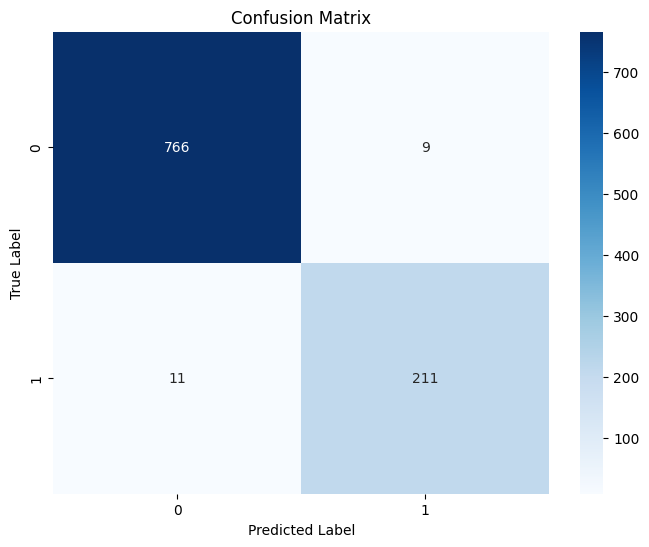

In [23]:
# Confusion matrix
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(df_test['labels'], df_test['prediction'])
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix')
plt.show()

Run on entire dataset

In [31]:
# read in data
all_reviews = pd.read_csv("./all_restaurant_bar_reviews.csv")
all_reviews.head()

,review_id,user_id,business_id,stars,useful,funny,cool,text,date,city,year
0,saUsX_uimxRlCVr67Z4Jig,8g_iMtfSiwikVnbP2etR0A,YjUWPpI6HXG530lwP-fb2A,3,0,0,0,Family diner. Had the buffet. Eclectic assortm...,2014-02-05 20:30:30,tucson,2014
1,AqPFMleE6RsU23_auESxiA,_7bHUi9Uuf5__HHc_Q8guQ,kxX2SOes4o-D3ZQBkiMRfA,5,1,0,1,"Wow! Yummy, different, delicious. Our favo...",2015-01-04 00:01:03,philadelphia,2015
2,Sx8TMOWLNuJBWer-0pcmoA,bcjbaE6dDog4jkNY91ncLQ,e4Vwtrqf-wpJfwesgvdgxQ,4,1,0,1,Cute interior and owner (?) gave us tour of up...,2017-01-14 20:54:15,new orleans,2017
3,JrIxlS1TzJ-iCu79ul40cQ,eUta8W_HdHMXPzLBBZhL1A,04UD14gamNjLY0IDYVhHJg,1,1,2,1,I am a long term frequent customer of this est...,2015-09-23 23:10:31,philadelphia,2015
4,pUycOfUwM8vqX7KjRRhUEA,59MxRhNVhU9MYndMkz0wtw,gebiRewfieSdtt17PTW6Zg,3,0,0,0,Had a party of 6 here for hibachi. Our waitres...,2016-07-25 07:31:06,santa barbara,2016


In [32]:
# prepare data for classifying
review_df = all_reviews[['review_id', 'text']]
review_df.head()

,review_id,text
0,saUsX_uimxRlCVr67Z4Jig,Family diner. Had the buffet. Eclectic assortm...
1,AqPFMleE6RsU23_auESxiA,"Wow! Yummy, different, delicious. Our favo..."
2,Sx8TMOWLNuJBWer-0pcmoA,Cute interior and owner (?) gave us tour of up...
3,JrIxlS1TzJ-iCu79ul40cQ,I am a long term frequent customer of this est...
4,pUycOfUwM8vqX7KjRRhUEA,Had a party of 6 here for hibachi. Our waitres...


In [33]:
# Tokenize the full dataset first
full_tokenized = Dataset.from_pandas(review_df).map(tokenize_function, batched=True)
full_tokenized

Map:   0%|          | 0/3025804 [00:00<?, ? examples/s]

Dataset({
    features: ['review_id', 'text', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 3025804
})

In [36]:
# Save the trained model
trainer.save_model("./live_music_bert_model")
tokenizer.save_pretrained("./live_music_bert_model")
print("Model saved!")

Model saved!


In [ ]:
# Load saved model
tokenizer = AutoTokenizer.from_pretrained("./live_music_bert_model")
model_ft = AutoModelForSequenceClassification.from_pretrained("./live_music_bert_model")
trainer = Trainer(model=model_ft)
print("Model loaded!")

In [35]:
# use chunked processing
import time
from tqdm import tqdm

chunk_size = 100000  # Process 100K at a time
all_predictions = []

for i in tqdm(range(0, len(review_df), chunk_size)):
    chunk_df = review_df[i:i+chunk_size]
    chunk_tokenized = full_tokenized.select(range(i, min(i + chunk_size, len(full_tokenized))))

    start = time.time()
    chunk_results = trainer.predict(chunk_tokenized)
    chunk_predictions = np.argmax(chunk_results.predictions, axis=-1)
    all_predictions.extend(chunk_predictions)
    
    print(f"Chunk {i//chunk_size + 1}: {len(chunk_df)} samples in {time.time()-start:.1f}s")

  0%|          | 0/31 [00:00<?, ?it/s]/Users/jeff/Projects/spatial_dist_of_music/code/llm_work/venv/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)
  0%|          | 0/31 [00:24<?, ?it/s]


KeyboardInterrupt: 

In [ ]:
output_df = review_df.copy()
output_df['live_music'] = all_predictions
output_df.to_csv('reviews_with_live_music.csv', index=False)